## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Prepare Data

In [4]:
from sklearn.datasets import load_iris

In [5]:
## Prepare Datafrom sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, :2]  # sepal length, sepal width 두 개 특성만 사용 (2D 시각화를 위해)
y = (iris.target == 0).astype(int)  # Setosa 1, 나머지는 0

In [6]:
# Tensor 변환
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

In [7]:
def plot_decision_boundary(X, y, model=None, threshold=0.5, resolution=300):
    """
    2D 입력에 대해 모델의 decision boundary를 시각화하는 함수

    Args:
        X: 입력 데이터, shape (N, 2), numpy array
        y: 정답 레이블, shape (N,), numpy array (0/1)
        model: PyTorch 모델 (입력 2차원, 출력 스칼라 확률)
        threshold: decision boundary 기준 (기본 0.5)
        resolution: 메쉬 그리드 해상도
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    
    plt.figure(figsize=(8,6))

    if model is not None:
        with torch.no_grad():
            preds = model(grid_tensor).reshape(xx.shape).numpy()
        plt.contourf(xx, yy, preds < threshold, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label='Setosa(y=1)')
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label='Non-Setosa(y=0)')

    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.legend()
    plt.show()

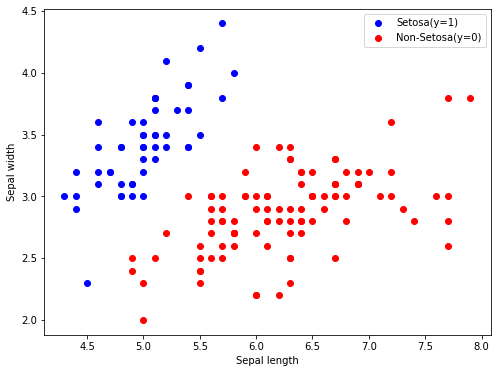

In [8]:
plot_decision_boundary(X, y)

## 3. MLP

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = MLP()

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4. 학습
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(X_tensor)
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: {loss}")

Epoch 0: 0.7401880621910095
Epoch 100: 0.14158979058265686
Epoch 200: 0.04866298288106918
Epoch 300: 0.03183317184448242
Epoch 400: 0.02441629022359848
Epoch 500: 0.019730573520064354
Epoch 600: 0.01626531034708023
Epoch 700: 0.013554857112467289
Epoch 800: 0.011400277726352215
Epoch 900: 0.009681036695837975


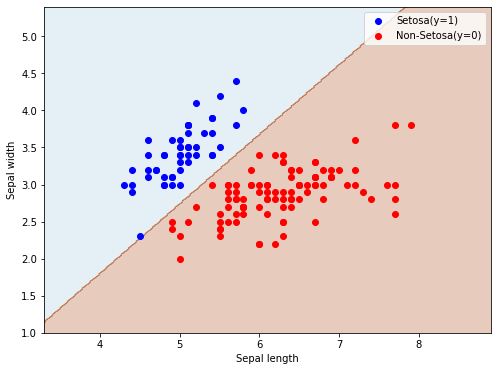

In [11]:
plot_decision_boundary(X, y, model)

## 4. NAM

In [12]:
class NAM(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.n_features = n_features
        
        functions = []
        for i in range(n_features):
            functions.append(self.get_function())
        self.functions = nn.ModuleList(functions)
        
    def forward(self, x):
        pred = 0
        for i in range(self.n_features):
            out = self.functions[i](x[:, i:i+1])
            pred += out
        pred = nn.Sigmoid()(pred)
        return pred

    def get_function(self):
        return nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    
n_features = 2
model = NAM(n_features)

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4. 학습
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(X_tensor)
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: {loss}")

Epoch 0: 0.6258946657180786
Epoch 100: 0.026808535680174828
Epoch 200: 0.00952091719955206
Epoch 300: 0.005470326170325279
Epoch 400: 0.003517549717798829
Epoch 500: 0.002335198689252138
Epoch 600: 0.0016202169936150312
Epoch 700: 0.0011834450997412205
Epoch 800: 0.0008905231952667236
Epoch 900: 0.0006824568845331669


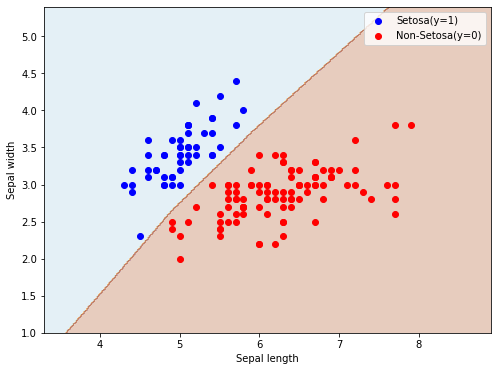

In [14]:
plot_decision_boundary(X, y, model)

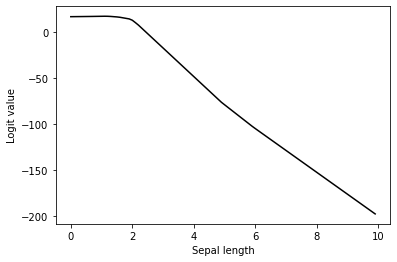

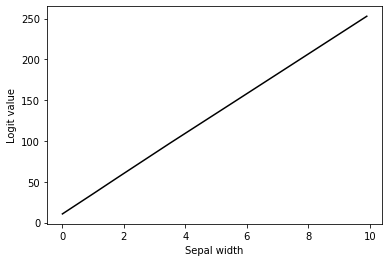

In [15]:
x = torch.arange(0, 10, 0.1).float()
y1 = model.functions[0](x.view(-1, 1))
y2 = model.functions[1](x.view(-1, 1))

plt.plot(x.detach().numpy(), y1.detach().numpy(), color='k')
plt.ylabel('Logit value')
plt.xlabel('Sepal length')
plt.show()

plt.plot(x.detach().numpy(), y2.detach().numpy(), color='k')
plt.xlabel('Sepal width')
plt.ylabel('Logit value')
plt.show()

Find more info  https://github.com/Harry24k/neural-additive-model-pytorch/tree/main